<a href="https://colab.research.google.com/github/leodavidfan/AI_Books/blob/main/EM_GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Imagine you have a bunch of dots scattered on a piece of paper, and you think these dots form natural groups or clusters, but they overlap a bit. A GMM helps find these groups, even when they're not perfectly separated.

Let's break it down step by step:

1. **Data Generation (`generate_synthetic_data`)**
```python
def generate_synthetic_data(n_samples=600, random_seed=42):
```
- This creates fake test data to practice with
- It makes 3 groups of dots, each centered at different points
- Think of throwing darts that tend to cluster around three different targets

2. **Initialization (`kmeans_initialize`)**
```python
def kmeans_initialize(X, K, max_iter=100, random_seed=42):
```
- Before we start the main algorithm, we need rough guesses for where our groups might be
- It's like taking a quick first look at the data and making initial guesses
- Uses a simpler method (K-means) to get these initial guesses

3. **The Main Parts of GMM**

a) **Gaussian Probability (`gaussian_pdf`)**
```python
def gaussian_pdf(X, mean, cov):
```
- For each dot, calculates how likely it belongs to each group
- Think of it as measuring how close a point is to the center of each group, but in a special way that accounts for the shape of the group

b) **E-step (Expectation)**
```python
def e_step(X, pis, mus, covs):
```
- For each dot, figures out the probability it belongs to each group
- Like saying "this dot is 70% likely to be in group 1, 20% in group 2, and 10% in group 3"

c) **M-step (Maximization)**
```python
def m_step(X, gammas):
```
- Updates our understanding of each group based on the probabilities we calculated
- Adjusts:
  - Where each group is centered
  - How spread out each group is
  - How big each group is compared to the others

4. **Main Algorithm (`fit_gmm_em`)**
```python
def fit_gmm_em(X, K, max_iter=200, tol=1e-5):
```
- Repeatedly does E-step then M-step until the groups stop changing much
- Like focusing a camera - each iteration makes the picture a little clearer

5. **Visualization (`plot_clusters_2d`)**
```python
def plot_clusters_2d(X, gammas, mus, covs, title="GMM Clusters"):
```
- Shows the results by:
  - Coloring each dot based on its group
  - Drawing circles/ovals to show where each group is centered and how spread out it is
  - Adding helpful labels and titles

The process is like playing a game:
1. Make some initial guesses about the groups
2. For each dot, calculate how likely it belongs to each group
3. Update the groups based on these calculations
4. Repeat steps 2-3 until things stop changing much


Iteration 10 | Log-Likelihood: -2374.328654
Converged after 10 iterations!


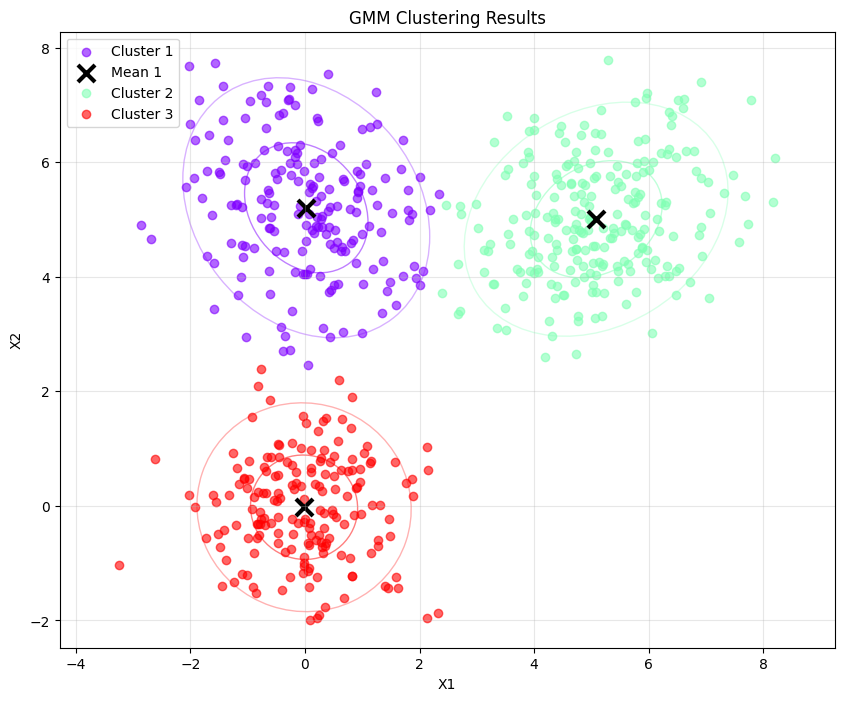

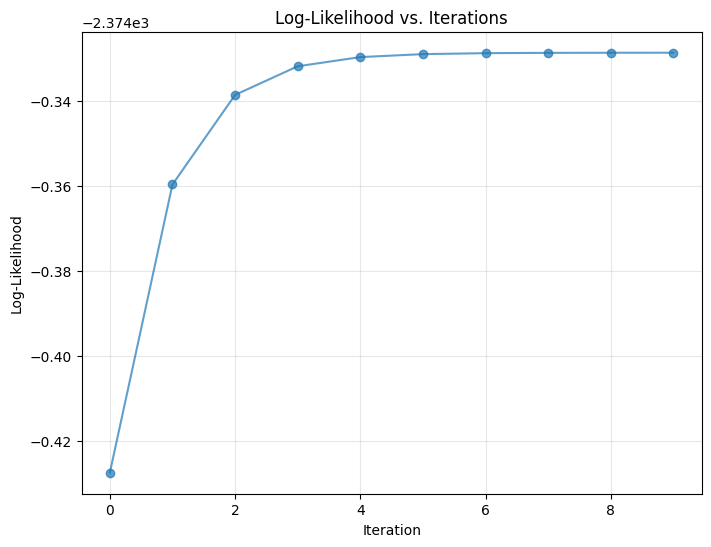

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def generate_synthetic_data(n_samples=600, random_seed=42):
    """
    Generates synthetic 2D data from three Gaussian distributions.

    Parameters
    ----------
    n_samples : int
        Total number of data points to generate.
    random_seed : int
        Seed for reproducibility.

    Returns
    -------
    X : np.ndarray of shape (n_samples, 2)
        Generated data points.
    true_labels : np.ndarray of shape (n_samples,)
        True cluster labels.
    """
    np.random.seed(random_seed)

    true_means = np.array([
        [0, 0],
        [5, 5],
        [0, 5]
    ])

    true_covs = np.array([
        [[1.0, 0.0], [0.0, 1.0]],
        [[1.5, 0.2], [0.2, 1.0]],
        [[1.0, -0.4], [-0.4, 1.5]]
    ])

    pis = [0.3, 0.4, 0.3]
    cluster_sizes = (n_samples * np.array(pis)).astype(int)

    X = []
    labels = []
    for i, size in enumerate(cluster_sizes):
        X_i = np.random.multivariate_normal(mean=true_means[i],
                                          cov=true_covs[i],
                                          size=size)
        X.append(X_i)
        labels += [i] * size

    X = np.vstack(X)
    labels = np.array(labels)
    shuffle_indices = np.random.permutation(len(X))

    return X[shuffle_indices], labels[shuffle_indices]

def kmeans_initialize(X, K, max_iter=100, random_seed=42):
    """
    Initialize cluster parameters using K-means clustering.
    """
    np.random.seed(random_seed)
    n_samples, D = X.shape

    # Initialize centroids using K-means++ strategy
    centroids = [X[np.random.randint(n_samples)]]
    for _ in range(1, K):
        # Compute distances to existing centroids
        distances = np.min([np.sum((X - c) ** 2, axis=1) for c in centroids], axis=0)
        # Choose next centroid with probability proportional to distance squared
        probs = distances / distances.sum()
        cumprobs = np.cumsum(probs)
        r = np.random.rand()
        new_centroid_idx = np.searchsorted(cumprobs, r)
        centroids.append(X[new_centroid_idx])

    centroids = np.array(centroids)

    for _ in range(max_iter):
        # Assign points to nearest centroid
        distances = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
        labels = np.argmin(distances, axis=1)

        # Update centroids
        new_centroids = np.array([X[labels == k].mean(axis=0) if np.sum(labels == k) > 0
                                else X[np.random.choice(n_samples)]
                                for k in range(K)])

        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    # Initialize GMM parameters
    pis = np.ones(K) / K
    mus = centroids

    # Initialize covariances using cluster assignments
    covs = []
    for k in range(K):
        cluster_points = X[labels == k]
        if len(cluster_points) > 1:
            cov = np.cov(cluster_points.T) + 1e-6 * np.eye(D)
        else:
            cov = np.eye(D)
        covs.append(cov)

    return pis, mus, covs

def gaussian_pdf(X, mean, cov):
    """
    Compute multivariate Gaussian probability density function.
    """
    n_samples, D = X.shape

    # Ensure numerical stability
    min_covar = 1e-7
    cov = cov + min_covar * np.eye(D)

    # Compute determinant and inverse with stability checks
    try:
        L = np.linalg.cholesky(cov)
        det = np.prod(np.diagonal(L)) ** 2
        inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        # If Cholesky fails, try eigendecomposition
        eigvals, eigvecs = np.linalg.eigh(cov)
        eigvals = np.maximum(eigvals, min_covar)
        det = np.prod(eigvals)
        inv = eigvecs @ np.diag(1.0 / eigvals) @ eigvecs.T

    norm_const = 1.0 / np.sqrt((2 * np.pi) ** D * det)

    # Compute Mahalanobis distance
    diff = X - mean
    maha_dist = np.sum(diff @ inv * diff, axis=1)

    return norm_const * np.exp(-0.5 * maha_dist)

def e_step(X, pis, mus, covs):
    """
    E-step: Compute responsibilities (posterior probabilities).
    """
    n_samples = X.shape[0]
    K = len(pis)

    # Compute weighted Gaussian probabilities
    weighted_pdfs = np.zeros((n_samples, K))
    for k in range(K):
        weighted_pdfs[:, k] = pis[k] * gaussian_pdf(X, mus[k], covs[k])

    # Normalize to get posteriors
    total_pdf = np.sum(weighted_pdfs, axis=1, keepdims=True)
    total_pdf = np.maximum(total_pdf, 1e-300)  # Prevent division by zero
    gammas = weighted_pdfs / total_pdf

    return gammas

def m_step(X, gammas):
    """
    M-step: Update GMM parameters.
    """
    n_samples, D = X.shape
    K = gammas.shape[1]

    # Compute effective number of points per cluster
    Nk = np.sum(gammas, axis=0)

    # Update mixing coefficients
    pis = Nk / n_samples

    # Update means
    mus = np.zeros((K, D))
    for k in range(K):
        mus[k] = (gammas[:, k, None] * X).sum(axis=0) / (Nk[k] + 1e-10)

    # Update covariances with improved stability
    covs = []
    min_covar = 1e-6

    for k in range(K):
        diff = X - mus[k]
        weighted_diff = gammas[:, k, None] * diff
        cov_k = (weighted_diff.T @ diff) / (Nk[k] + 1e-10)

        # Ensure symmetry
        cov_k = (cov_k + cov_k.T) / 2

        # Add regularization
        cov_k += min_covar * np.eye(D)

        # Ensure positive definiteness
        eigvals, eigvecs = np.linalg.eigh(cov_k)
        eigvals = np.maximum(eigvals, min_covar)
        cov_k = eigvecs @ np.diag(eigvals) @ eigvecs.T

        covs.append(cov_k)

    return pis, mus, covs

def compute_log_likelihood(X, pis, mus, covs):
    """
    Compute the log-likelihood of the data under current parameters.
    """
    n_samples = X.shape[0]
    K = len(pis)

    weighted_pdfs = np.zeros((n_samples, K))
    for k in range(K):
        weighted_pdfs[:, k] = pis[k] * gaussian_pdf(X, mus[k], covs[k])

    total_pdf = np.sum(weighted_pdfs, axis=1)
    total_pdf = np.maximum(total_pdf, 1e-300)  # Prevent log(0)
    log_likelihood = np.sum(np.log(total_pdf))

    return log_likelihood

def fit_gmm_em(X, K, max_iter=200, tol=1e-5, initialization='kmeans',
               random_seed=42, verbose=True):
    """
    Fit GMM using EM algorithm.
    """
    np.random.seed(random_seed)
    n_samples, D = X.shape

    # Initialize parameters
    if initialization == 'kmeans':
        pis, mus, covs = kmeans_initialize(X, K, random_seed=random_seed)
    else:
        pis = np.ones(K) / K
        idx = np.random.choice(n_samples, K, replace=False)
        mus = X[idx]
        covs = [np.eye(D) for _ in range(K)]

    # EM iterations
    log_likelihoods = []
    prev_ll = None
    best_params = None
    best_ll = float('-inf')

    for iteration in range(1, max_iter + 1):
        # E-step
        gammas = e_step(X, pis, mus, covs)

        # M-step
        pis, mus, covs = m_step(X, gammas)

        # Compute log-likelihood
        ll = compute_log_likelihood(X, pis, mus, covs)
        log_likelihoods.append(ll)

        # Track best parameters
        if ll > best_ll:
            best_ll = ll
            best_params = (pis.copy(), mus.copy(), [cov.copy() for cov in covs])

        if verbose and iteration % 10 == 0:
            print(f"Iteration {iteration} | Log-Likelihood: {ll:.6f}")

        # Check convergence
        if prev_ll is not None:
            change = abs(ll - prev_ll)
            if change < tol:
                if verbose:
                    print(f"Converged after {iteration} iterations!")
                break

        prev_ll = ll

    # Return best parameters found
    pis, mus, covs = best_params
    final_gammas = e_step(X, pis, mus, covs)

    return pis, mus, covs, final_gammas, log_likelihoods

def plot_clusters_2d(X, gammas, mus, covs, title="GMM Clusters"):
    """
    Plot 2D data points colored by cluster assignment with covariance ellipses.
    """
    cluster_assignments = np.argmax(gammas, axis=1)
    K = mus.shape[0]

    plt.figure(figsize=(10, 8))
    colors = plt.cm.rainbow(np.linspace(0, 1, K))

    for k in range(K):
        cluster_points = X[cluster_assignments == k]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                   c=[colors[k]], label=f'Cluster {k+1}', alpha=0.6)

        # Plot mean
        plt.scatter(mus[k, 0], mus[k, 1], c='black', marker='x',
                   s=150, linewidths=3, label=f'Mean {k+1}' if k == 0 else "")

        # Plot covariance ellipse
        eigvals, eigvecs = np.linalg.eigh(covs[k])
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))

        for nstd in [1, 2]:
            ellip = Ellipse(xy=mus[k],
                          width=2*nstd*np.sqrt(eigvals[0]),
                          height=2*nstd*np.sqrt(eigvals[1]),
                          angle=angle,
                          facecolor='none',
                          edgecolor=colors[k],
                          alpha=0.3 if nstd == 2 else 0.5)
            plt.gca().add_patch(ellip)

    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()

def main():
    # Generate synthetic data
    X, true_labels = generate_synthetic_data(n_samples=600, random_seed=42)

    # Fit GMM
    K = 3
    pis, mus, covs, gammas, ll_history = fit_gmm_em(
        X, K, max_iter=100, tol=1e-5,
        initialization='kmeans',
        random_seed=42,
        verbose=True
    )

    # Plot results
    plot_clusters_2d(X, gammas, mus, covs,
                    title="GMM Clustering Results")

    # Plot log-likelihood history
    plt.figure(figsize=(8, 6))
    plt.plot(ll_history, '-o', alpha=0.7)
    plt.title("Log-Likelihood vs. Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Log-Likelihood")
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    main()